In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

import numpy as np
import random
import gc
from tqdm import tqdm
from glob import glob

## 1. 데이터 전처리

데이터 증강을 통해 정확도를 높일 것인데, 전체를 증가시키면 아무 의미 없음으로 26번을 제외하고 증가시킨다.

In [2]:
# 데이터 불러오기

path = './data/'
train = pd.read_csv(path + 'train_features.csv')
train_label = pd.read_csv(path + 'train_labels.csv')
test = pd.read_csv(path + 'test_features.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

<AxesSubplot:>

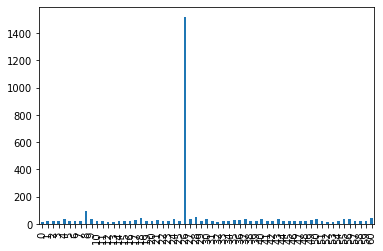

In [3]:
# 26번만 비정상적으로 많음
train_label['label'].value_counts().plot.bar()

In [4]:
# 정확한 수치를 확인해 보았다. 26번이 적폐 수준... 데이터의 반을 차지한다.
train_label['label'].value_counts()

26    1518
8       97
28      55
60      48
18      47
      ... 
53      13
52      12
13      12
12      12
0       12
Name: label, Length: 61, dtype: int64

In [5]:
# 26번을 제외한 id 리스트
feature = list(train_label[train_label['label'] != 26]['id'])

In [6]:
# train 데이터에서 26번을 삭제시킨다.
temp = []
for n in tqdm(range(train.shape[0])):
    if train['id'][n] in feature:
        temp.append(train.iloc[n])

100%|██████████████████████████████████████████████████████████████████████| 1875000/1875000 [06:14<00:00, 5005.96it/s]


In [7]:
# 26번을 삭제시킨 데이터프레임
without = pd.DataFrame(data=np.array(temp), columns=train.columns)
without = without.astype({'id':int, 'time':int})
without

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
964195,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
964196,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
964197,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
964198,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


In [8]:
# https://dacon.io/competitions/official/235689/codeshare/2347?page=1&dtype=recent&ptype=pub
# 데이터 증강을 통해 과접합을 줄여보자 - DACON
# 증강할 데이터 정리

without_train = []

for uid in tqdm(without['id'].unique()):
    temp = np.array(without[without['id'] == uid].iloc[:,2:], np.float32).T
    without_train.append(temp)

without_train = np.array(without_train, np.float32)
without_train = without_train[:,:,:,np.newaxis].reshape(-1,600,6)

without_label = train_label[train_label['label'] != 26]['label']

100%|█████████████████████████████████████████████████████████████████████████████| 1607/1607 [00:02<00:00, 714.90it/s]


In [9]:
# https://dacon.io/competitions/official/235689/codeshare/2347?page=1&dtype=recent&ptype=pub
# 데이터 증강을 통해 과접합을 줄여보자 - DACON
# 원본 데이터 정리
import tensorflow as tf

x_train = []

for uid in tqdm(train['id'].unique()):
    temp = np.array(train[train['id'] == uid].iloc[:,2:], np.float32).T
    x_train.append(temp)

x_train = np.array(x_train, np.float32)
x_train = x_train[:,:,:,np.newaxis].reshape(-1,600,6)

y_train = train_label['label']
y_categorical = tf.keras.utils.to_categorical(y_train)

x_test = []

for uid in tqdm(test['id'].unique()):
    temp = np.array(test[test['id'] == uid].iloc[:,2:], np.float32).T
    x_test.append(temp)

x_test = np.array(x_test, np.float32)
x_test = x_test[:,:,:,np.newaxis].reshape(-1,600,6)

100%|██████████████████████████████████████████████████████████████████████████████| 782/782 [00:00<00:00, 1718.29it/s]


In [12]:
def aug(data, shift):
    shift_data = np.roll(data, shift, axis=2)
    return shift_data

# 데이터 증강
shift_data = []
shift_label = []
for n in tqdm(range(20)):
    shifted = aug(without_train, n*30)
    shift_data.append(shifted)
    shift_label.append(without_label)

shift_data = np.array(shift_data).reshape(-1,600,6)
shift_label = np.array(shift_label).reshape(-1,1)
shift_categorical = tf.keras.utils.to_categorical(shift_label)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 325.10it/s]


In [13]:
# 원본 데이터와 증강 데이터 합치기
concat_train = np.concatenate((x_train, shift_data), axis=0)
concat_label = np.concatenate((y_categorical, shift_categorical), axis=0)
print(concat_train.shape)
print(concat_label.shape)

(35265, 600, 6)
(35265, 61)


## NN 모델링

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [16]:
# 모델 1번: lstm

def build_cnn(split_num, train, target, test, rnd):
    # return train pred prob and test pred prob 
    train_pred, test_pred = np.zeros((train.shape[0], 61)), np.zeros((test.shape[0], 61))

    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    mc = tf.keras.callbacks.ModelCheckpoint(filepath='./model/lstm.h5',save_weights_only=True,monitor='loss',mode='min',save_best_only=True)
    
    mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, val_idx in mskf.split(train, target):

        # split train, validation set
        X = train[train_idx]
        y = target[train_idx]
        valid_x = train[val_idx]
        valid_y = target[val_idx]

        #가벼운 모델 생성
        model = Sequential()
        model.add(LSTM(32, input_shape=(600,6)))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(61, activation='softmax'))

        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

        model.fit(X,y,
                  epochs=100,
                  batch_size=64,
                  validation_data=[valid_x,valid_y],
                  callbacks=[es,mc]
                 )
        
        # save feat
        model.load_weights('./model/lstm.h5')
        train_pred[val_idx] = model.predict(valid_x)
        test_pred += model.predict(test)/split_num
        
        # release
        del model
        gc.collect()
        print('------------------')
        
    return train_pred, test_pred

cnn_train1, cnn_test1 = build_cnn(5, concat_train, concat_label, x_test, 1)
cnn_train2, cnn_test2 = build_cnn(5, concat_train, concat_label, x_test, 2)

c:\users\pc\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Train on 28212 samples, validate on 7053 samples
Epoch 1/100
28212/28212 [==============================] - 740s 26ms/sample - loss: 3.3602 - accuracy: 0.1472 - val_loss: 2.8865 - val_accuracy: 0.2148
Epoch 2/100
28212/28212 [==============================] - 12s 439us/sample - loss: 2.6386 - accuracy: 0.2794 - val_loss: 2.4490 - val_accuracy: 0.3197
Epoch 3/100
28212/28212 [==============================] - 12s 441us/sample - loss: 2.3011 - accuracy: 0.3613 - val_loss: 2.1857 - val_accuracy: 0.3915
Epoch 4/100
28212/28212 [==============================] - 13s 444us/sample - loss: 2.0494 - accuracy: 0.4233 - val_loss: 1.9674 - val_accuracy: 0.4475
Epoch 5/100
28212/28212 [==============================] - 12s 440us/sample - loss: 1.8480 - accuracy: 0.4769 - val_loss: 1.7835 - val_accuracy: 0.5038
Epoch 6/100
28212/28212 [==============================] - 12s 439us/sample - loss: 1.6706 - accuracy: 0.5309 - val_loss: 1.6348 - val_accuracy: 0.5334
Epoch 7/100
28212/28212 [==============

28212/28212 [==============================] - 12s 438us/sample - loss: 0.0854 - accuracy: 0.9792 - val_loss: 0.1426 - val_accuracy: 0.9682
Epoch 55/100
28212/28212 [==============================] - 13s 446us/sample - loss: 0.0835 - accuracy: 0.9797 - val_loss: 0.1454 - val_accuracy: 0.9697
Epoch 56/100
28212/28212 [==============================] - 13s 462us/sample - loss: 0.0767 - accuracy: 0.9819 - val_loss: 0.1132 - val_accuracy: 0.9758
Epoch 57/100
28212/28212 [==============================] - 13s 462us/sample - loss: 0.0863 - accuracy: 0.9814 - val_loss: 0.1104 - val_accuracy: 0.9762
Epoch 58/100
28212/28212 [==============================] - 13s 468us/sample - loss: 0.0747 - accuracy: 0.9821 - val_loss: 0.2517 - val_accuracy: 0.9414
Epoch 59/100
28212/28212 [==============================] - 13s 452us/sample - loss: 0.0737 - accuracy: 0.9829 - val_loss: 0.1080 - val_accuracy: 0.9777
Epoch 60/100
28212/28212 [==============================] - 13s 454us/sample - loss: 0.0796 - a

28212/28212 [==============================] - 12s 426us/sample - loss: 0.2356 - accuracy: 0.9412 - val_loss: 0.2285 - val_accuracy: 0.9465
Epoch 37/100
28212/28212 [==============================] - 12s 428us/sample - loss: 0.2056 - accuracy: 0.9493 - val_loss: 0.2772 - val_accuracy: 0.9314
Epoch 38/100
28212/28212 [==============================] - 12s 428us/sample - loss: 0.2140 - accuracy: 0.9467 - val_loss: 0.3433 - val_accuracy: 0.9000
Epoch 39/100
28212/28212 [==============================] - 12s 427us/sample - loss: 0.1950 - accuracy: 0.9525 - val_loss: 0.2746 - val_accuracy: 0.9416
Epoch 40/100
28212/28212 [==============================] - 12s 425us/sample - loss: 0.1840 - accuracy: 0.9557 - val_loss: 0.2291 - val_accuracy: 0.9406
Epoch 41/100
28212/28212 [==============================] - 12s 425us/sample - loss: 0.1739 - accuracy: 0.9570 - val_loss: 0.1637 - val_accuracy: 0.9648
Epoch 42/100
28212/28212 [==============================] - 12s 425us/sample - loss: 0.1798 - a

28212/28212 [==============================] - 12s 438us/sample - loss: 0.7380 - accuracy: 0.8045 - val_loss: 0.7100 - val_accuracy: 0.8144
Epoch 14/100
28212/28212 [==============================] - 12s 435us/sample - loss: 0.6653 - accuracy: 0.8274 - val_loss: 0.8457 - val_accuracy: 0.7690
Epoch 15/100
28212/28212 [==============================] - 12s 435us/sample - loss: 0.6002 - accuracy: 0.8462 - val_loss: 0.5521 - val_accuracy: 0.8622
Epoch 16/100
28212/28212 [==============================] - 12s 432us/sample - loss: 0.5303 - accuracy: 0.8648 - val_loss: 0.5012 - val_accuracy: 0.8761
Epoch 17/100
28212/28212 [==============================] - 12s 435us/sample - loss: 0.4746 - accuracy: 0.8824 - val_loss: 0.4894 - val_accuracy: 0.8744
Epoch 18/100
28212/28212 [==============================] - 12s 436us/sample - loss: 0.4516 - accuracy: 0.8878 - val_loss: 0.4109 - val_accuracy: 0.8995
Epoch 19/100
28212/28212 [==============================] - 12s 433us/sample - loss: 0.4063 - a

28212/28212 [==============================] - 12s 433us/sample - loss: 0.0722 - accuracy: 0.9835 - val_loss: 0.1158 - val_accuracy: 0.9759
Epoch 67/100
28212/28212 [==============================] - 12s 434us/sample - loss: 0.0776 - accuracy: 0.9809 - val_loss: 0.0962 - val_accuracy: 0.9797
------------------
Train on 28212 samples, validate on 7053 samples
Epoch 1/100
28212/28212 [==============================] - 13s 477us/sample - loss: 3.3682 - accuracy: 0.1395 - val_loss: 2.9101 - val_accuracy: 0.2062
Epoch 2/100
28212/28212 [==============================] - 12s 434us/sample - loss: 2.6574 - accuracy: 0.2596 - val_loss: 2.4514 - val_accuracy: 0.3192
Epoch 3/100
28212/28212 [==============================] - 12s 435us/sample - loss: 2.2959 - accuracy: 0.3514 - val_loss: 2.1737 - val_accuracy: 0.3762
Epoch 4/100
28212/28212 [==============================] - 12s 433us/sample - loss: 2.0394 - accuracy: 0.4171 - val_loss: 1.9461 - val_accuracy: 0.4425
Epoch 5/100
28212/28212 [======

28212/28212 [==============================] - 12s 435us/sample - loss: 0.1008 - accuracy: 0.9747 - val_loss: 0.2116 - val_accuracy: 0.9471
Epoch 53/100
28212/28212 [==============================] - 12s 434us/sample - loss: 0.0979 - accuracy: 0.9760 - val_loss: 0.1542 - val_accuracy: 0.9630
Epoch 54/100
28212/28212 [==============================] - 12s 437us/sample - loss: 0.0982 - accuracy: 0.9755 - val_loss: 0.1444 - val_accuracy: 0.9687
Epoch 55/100
28212/28212 [==============================] - 12s 434us/sample - loss: 0.0952 - accuracy: 0.9759 - val_loss: 0.1605 - val_accuracy: 0.9647
Epoch 56/100
28212/28212 [==============================] - 12s 436us/sample - loss: 0.0972 - accuracy: 0.9765 - val_loss: 0.1530 - val_accuracy: 0.9685
Epoch 57/100
28212/28212 [==============================] - 12s 436us/sample - loss: 0.0924 - accuracy: 0.9767 - val_loss: 0.1539 - val_accuracy: 0.9638
Epoch 58/100
28212/28212 [==============================] - 12s 434us/sample - loss: 0.0947 - a

28212/28212 [==============================] - 12s 426us/sample - loss: 0.2992 - accuracy: 0.9289 - val_loss: 0.2823 - val_accuracy: 0.9386
Epoch 23/100
28212/28212 [==============================] - 12s 425us/sample - loss: 0.2807 - accuracy: 0.9333 - val_loss: 0.3711 - val_accuracy: 0.9051
Epoch 24/100
28212/28212 [==============================] - 12s 427us/sample - loss: 0.2627 - accuracy: 0.9377 - val_loss: 0.2831 - val_accuracy: 0.9294
Epoch 25/100
28212/28212 [==============================] - 12s 425us/sample - loss: 0.2493 - accuracy: 0.9398 - val_loss: 0.2530 - val_accuracy: 0.9457
Epoch 26/100
28212/28212 [==============================] - 12s 426us/sample - loss: 0.2310 - accuracy: 0.9447 - val_loss: 0.2568 - val_accuracy: 0.9376
Epoch 27/100
28212/28212 [==============================] - 12s 427us/sample - loss: 0.2146 - accuracy: 0.9482 - val_loss: 0.2393 - val_accuracy: 0.9464
Epoch 28/100
28212/28212 [==============================] - 12s 426us/sample - loss: 0.2079 - a

28212/28212 [==============================] - 12s 424us/sample - loss: 0.0676 - accuracy: 0.9840 - val_loss: 0.2689 - val_accuracy: 0.9305
Epoch 76/100
28212/28212 [==============================] - 12s 424us/sample - loss: 0.0582 - accuracy: 0.9845 - val_loss: 0.1427 - val_accuracy: 0.9702
Epoch 77/100
28212/28212 [==============================] - 12s 424us/sample - loss: 0.0584 - accuracy: 0.9852 - val_loss: 0.2124 - val_accuracy: 0.9390
Epoch 78/100
28212/28212 [==============================] - 12s 425us/sample - loss: 0.0596 - accuracy: 0.9852 - val_loss: 0.1278 - val_accuracy: 0.9731
Epoch 79/100
28212/28212 [==============================] - 12s 423us/sample - loss: 0.0616 - accuracy: 0.9842 - val_loss: 0.1099 - val_accuracy: 0.9766
Epoch 80/100
28212/28212 [==============================] - 12s 423us/sample - loss: 0.0617 - accuracy: 0.9850 - val_loss: 0.1870 - val_accuracy: 0.9487
Epoch 81/100
28212/28212 [==============================] - 12s 425us/sample - loss: 0.0530 - a

c:\users\pc\.conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass shuffle=True, random_state=42 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Train on 28212 samples, validate on 7053 samples
Epoch 1/100
28212/28212 [==============================] - 13s 464us/sample - loss: 3.4210 - accuracy: 0.1330 - val_loss: 3.0253 - val_accuracy: 0.1896
Epoch 2/100
28212/28212 [==============================] - 12s 425us/sample - loss: 2.7462 - accuracy: 0.2489 - val_loss: 2.5668 - val_accuracy: 0.2780
Epoch 3/100
28212/28212 [==============================] - 12s 425us/sample - loss: 2.3612 - accuracy: 0.3295 - val_loss: 2.2299 - val_accuracy: 0.3468
Epoch 4/100
28212/28212 [==============================] - 12s 425us/sample - loss: 2.0840 - accuracy: 0.3959 - val_loss: 2.0511 - val_accuracy: 0.4132
Epoch 5/100
28212/28212 [==============================] - 12s 425us/sample - loss: 1.8536 - accuracy: 0.4579 - val_loss: 1.7509 - val_accuracy: 0.4767
Epoch 6/100
28212/28212 [==============================] - 12s 427us/sample - loss: 1.6514 - accuracy: 0.5160 - val_loss: 1.5950 - val_accuracy: 0.5446
Epoch 7/100
28212/28212 [==============

28212/28212 [==============================] - 12s 428us/sample - loss: 0.0948 - accuracy: 0.9777 - val_loss: 0.8632 - val_accuracy: 0.8369
Epoch 55/100
28212/28212 [==============================] - 12s 427us/sample - loss: 0.0974 - accuracy: 0.9769 - val_loss: 0.1521 - val_accuracy: 0.9653
Epoch 56/100
28212/28212 [==============================] - 12s 427us/sample - loss: 0.0994 - accuracy: 0.9767 - val_loss: 0.1148 - val_accuracy: 0.9748
Epoch 57/100
28212/28212 [==============================] - 12s 429us/sample - loss: 0.0981 - accuracy: 0.9784 - val_loss: 0.1939 - val_accuracy: 0.9602
Epoch 58/100
28212/28212 [==============================] - 12s 429us/sample - loss: 0.0911 - accuracy: 0.9784 - val_loss: 0.1593 - val_accuracy: 0.9646
Epoch 59/100
28212/28212 [==============================] - 12s 428us/sample - loss: 0.0952 - accuracy: 0.9777 - val_loss: 0.1168 - val_accuracy: 0.9763
Epoch 60/100
28212/28212 [==============================] - 12s 427us/sample - loss: 0.0923 - a

28212/28212 [==============================] - 12s 424us/sample - loss: 0.3057 - accuracy: 0.9264 - val_loss: 0.3194 - val_accuracy: 0.9261
Epoch 26/100
28212/28212 [==============================] - 12s 425us/sample - loss: 0.2909 - accuracy: 0.9298 - val_loss: 0.3057 - val_accuracy: 0.9270
Epoch 27/100
28212/28212 [==============================] - 12s 425us/sample - loss: 0.2609 - accuracy: 0.9360 - val_loss: 0.2868 - val_accuracy: 0.9361
Epoch 28/100
28212/28212 [==============================] - 12s 425us/sample - loss: 0.2504 - accuracy: 0.9395 - val_loss: 0.2715 - val_accuracy: 0.9312
Epoch 29/100
28212/28212 [==============================] - 12s 425us/sample - loss: 0.2376 - accuracy: 0.9425 - val_loss: 0.2356 - val_accuracy: 0.9465
Epoch 30/100
28212/28212 [==============================] - 12s 425us/sample - loss: 0.2283 - accuracy: 0.9428 - val_loss: 0.2383 - val_accuracy: 0.9473
Epoch 31/100
28212/28212 [==============================] - 12s 426us/sample - loss: 0.2115 - a

28212/28212 [==============================] - 12s 426us/sample - loss: 0.2540 - accuracy: 0.9389 - val_loss: 0.2460 - val_accuracy: 0.9470
Epoch 30/100
28212/28212 [==============================] - 12s 427us/sample - loss: 0.2320 - accuracy: 0.9458 - val_loss: 0.2350 - val_accuracy: 0.9593
Epoch 31/100
28212/28212 [==============================] - 12s 427us/sample - loss: 0.2359 - accuracy: 0.9419 - val_loss: 0.2462 - val_accuracy: 0.9495
Epoch 32/100
28212/28212 [==============================] - 12s 429us/sample - loss: 0.2166 - accuracy: 0.9473 - val_loss: 0.2579 - val_accuracy: 0.9344
Epoch 33/100
28212/28212 [==============================] - 12s 428us/sample - loss: 0.2077 - accuracy: 0.9509 - val_loss: 0.2262 - val_accuracy: 0.9480
Epoch 34/100
28212/28212 [==============================] - 12s 428us/sample - loss: 0.1908 - accuracy: 0.9551 - val_loss: 0.2088 - val_accuracy: 0.9593
Epoch 35/100
28212/28212 [==============================] - 12s 426us/sample - loss: 0.1915 - a

28212/28212 [==============================] - 12s 426us/sample - loss: 0.6077 - accuracy: 0.8393 - val_loss: 0.6829 - val_accuracy: 0.8063
Epoch 18/100
28212/28212 [==============================] - 12s 425us/sample - loss: 0.5640 - accuracy: 0.8517 - val_loss: 0.6127 - val_accuracy: 0.8399
Epoch 19/100
28212/28212 [==============================] - 12s 425us/sample - loss: 0.5129 - accuracy: 0.8667 - val_loss: 0.5300 - val_accuracy: 0.8618
Epoch 20/100
28212/28212 [==============================] - 12s 424us/sample - loss: 0.4849 - accuracy: 0.8732 - val_loss: 0.4870 - val_accuracy: 0.8747
Epoch 21/100
28212/28212 [==============================] - 12s 424us/sample - loss: 0.4386 - accuracy: 0.8859 - val_loss: 0.4759 - val_accuracy: 0.8687
Epoch 22/100
28212/28212 [==============================] - 12s 425us/sample - loss: 0.4181 - accuracy: 0.8936 - val_loss: 0.4412 - val_accuracy: 0.8908
Epoch 23/100
28212/28212 [==============================] - 12s 424us/sample - loss: 0.3842 - a

28212/28212 [==============================] - 12s 435us/sample - loss: 1.9166 - accuracy: 0.4560 - val_loss: 1.8530 - val_accuracy: 0.4835
Epoch 6/100
28212/28212 [==============================] - 12s 426us/sample - loss: 1.7240 - accuracy: 0.5140 - val_loss: 1.6901 - val_accuracy: 0.5188
Epoch 7/100
28212/28212 [==============================] - 12s 433us/sample - loss: 1.5606 - accuracy: 0.5598 - val_loss: 1.5772 - val_accuracy: 0.5633
Epoch 8/100
28212/28212 [==============================] - 12s 437us/sample - loss: 1.4215 - accuracy: 0.5997 - val_loss: 1.4510 - val_accuracy: 0.5963
Epoch 9/100
28212/28212 [==============================] - 12s 427us/sample - loss: 1.2878 - accuracy: 0.6427 - val_loss: 1.2493 - val_accuracy: 0.6546
Epoch 10/100
28212/28212 [==============================] - 12s 427us/sample - loss: 1.1617 - accuracy: 0.6811 - val_loss: 1.1958 - val_accuracy: 0.6701
Epoch 11/100
28212/28212 [==============================] - 12s 427us/sample - loss: 1.0429 - accur

28212/28212 [==============================] - 12s 424us/sample - loss: 0.0995 - accuracy: 0.9768 - val_loss: 0.1410 - val_accuracy: 0.9722
Epoch 59/100
28212/28212 [==============================] - 12s 428us/sample - loss: 0.0901 - accuracy: 0.9789 - val_loss: 0.1463 - val_accuracy: 0.9718
Epoch 60/100
28212/28212 [==============================] - 12s 433us/sample - loss: 0.0819 - accuracy: 0.9798 - val_loss: 0.1535 - val_accuracy: 0.9670
Epoch 61/100
28212/28212 [==============================] - 12s 441us/sample - loss: 0.0857 - accuracy: 0.9800 - val_loss: 0.1546 - val_accuracy: 0.9726
Epoch 62/100
28212/28212 [==============================] - 13s 446us/sample - loss: 0.1028 - accuracy: 0.9758 - val_loss: 0.2046 - val_accuracy: 0.9515
Epoch 63/100
28212/28212 [==============================] - 13s 447us/sample - loss: 0.0779 - accuracy: 0.9816 - val_loss: 0.1493 - val_accuracy: 0.9668
Epoch 64/100
28212/28212 [==============================] - 13s 455us/sample - loss: 0.0726 - a

In [50]:
sample_submssion = pd.read_csv(path + 'sample_submission.csv')
sample_submssion.iloc[:,1:] = cnn_test1
sample_submssion.to_csv("lstm.csv", index = False)

## 4. ML 모델링

In [36]:
ml_train = np.array([np.max(concat_train, axis=1),np.min(concat_train, axis=1),np.mean(concat_train, axis=1)]).reshape(-1, 18)
ml_test = np.array([np.max(x_test, axis=1),np.min(x_test, axis=1),np.mean(x_test, axis=1)]).reshape(-1, 18)
ml_label = np.concatenate((np.array(y_train).reshape(-1,1), shift_label), axis=0)

In [40]:
ml_train.shape, ml_test.shape

((35265, 18), (782, 18))

In [41]:
# import lightgbm as lgb
import xgboost as xgb
# import catboost as cb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [43]:
# 모델 2번: xgboost

def build_xgboost(split_num, train, target, test, rnd):
    
    params = {
                'colsample_bytree': 0.7,
                'subsample': 0.8,
                'eta': 0.04,
                'max_depth': 12,
                'eval_metric':'mlogloss',
                'objective':'multi:softprob',
                'num_class':61,
                }
    
    # return train pred prob and test pred prob 
    train_pred, test_pred = np.zeros((train.shape[0], 61)), np.zeros((test.shape[0], 61))
    
    skf = StratifiedKFold(n_splits=split_num, shuffle=True, random_state=233*rnd)
    for train_idx, val_idx in skf.split(train, target):

        # split train, validation set
        X = train[train_idx]
        y = target[train_idx]
        valid_x = train[val_idx]
        valid_y = target[val_idx]

        d_train = xgb.DMatrix(X, y)
        d_valid = xgb.DMatrix(valid_x, valid_y)
        d_temp = xgb.DMatrix(valid_x)
        d_test = xgb.DMatrix(test)
        
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        
        #run traning
        model = xgb.train(params, d_train, 2000, watchlist, 
                        early_stopping_rounds=50,
                        verbose_eval=100)

        # save feat
        train_pred[val_idx] = model.predict(d_temp)
        test_pred += model.predict(d_test)/split_num
        
        # release
        del model
        gc.collect()
        print('------------------')
        
    return train_pred, test_pred

xgb_train1, xgb_test1 = build_xgboost(5, ml_train, ml_label, ml_test, 1)
xgb_train2, xgb_test2 = build_xgboost(5, ml_train, ml_label, ml_test, 2)

[0]	train-mlogloss:3.99914	valid-mlogloss:4.02074
[100]	train-mlogloss:0.92431	valid-mlogloss:1.28733
[200]	train-mlogloss:0.48641	valid-mlogloss:0.92702
[300]	train-mlogloss:0.32236	valid-mlogloss:0.86104
[375]	train-mlogloss:0.26589	valid-mlogloss:0.86279
------------------
[0]	train-mlogloss:4.00358	valid-mlogloss:4.02379
[100]	train-mlogloss:0.92590	valid-mlogloss:1.29619
[200]	train-mlogloss:0.48396	valid-mlogloss:0.93957
[300]	train-mlogloss:0.32275	valid-mlogloss:0.87711
[382]	train-mlogloss:0.26316	valid-mlogloss:0.88144
------------------
[0]	train-mlogloss:3.99327	valid-mlogloss:4.01504
[100]	train-mlogloss:0.92744	valid-mlogloss:1.31394
[200]	train-mlogloss:0.48634	valid-mlogloss:0.95626
[300]	train-mlogloss:0.32201	valid-mlogloss:0.89343
[367]	train-mlogloss:0.26995	valid-mlogloss:0.89692
------------------
[0]	train-mlogloss:4.00005	valid-mlogloss:4.02098
[100]	train-mlogloss:0.91342	valid-mlogloss:1.27217
[200]	train-mlogloss:0.48506	valid-mlogloss:0.91946
[300]	train-mlo

In [44]:
# # 모델 2번: catboost

# def build_catboost(split_num, train, target, test, rnd):
#     # return train pred prob and test pred prob 
#     train_pred, test_pred = np.zeros((train.shape[0], 61)), np.zeros((test.shape[0], 61))

#     skf = StratifiedKFold(n_splits=split_num, shuffle=True, random_state=233*rnd)
#     for train_idx, val_idx in skf.split(train, target):

#         # split train, validation set
#         X = train.iloc[train_idx]
#         y = target.iloc[train_idx]
#         valid_x = train.iloc[val_idx]
#         valid_y = target.iloc[val_idx]

#         model = cb.CatBoostClassifier(iterations=1500,
#                                       learning_rate=0.01,
#                                       l2_leaf_reg=3.5,
#                                       depth=8,
#                                       rsm=0.98,
#                                       loss_function= 'MultiClass',
#                                       eval_metric='AUC',
#                                       use_best_model=True,
#                                       random_seed=42,
#                                       verbose=50)

#         model.fit(X, y,
#                   eval_set=(valid_x, valid_y),
#                   early_stopping_rounds=30)
        
#         # save feat
#         train_pred[val_idx] = model.predict(valid_x)
#         test_pred += model.predict(test)/split_num
        
#         # release
#         del model
#         gc.collect()
#         print('------------------')
        
#     return train_pred, test_pred

# catboost_train1, catboost_test1 = build_catboost(5, ml_train, ml_label, ml_test, 1)
# catboost_train2, catboost_test2 = build_catboost(5, ml_train, ml_label, ml_test, 2)

In [45]:
# x_train = np.array(train.iloc[:,2:]).reshape(-1, 600, 6, 1)
# y_train = tf.keras.utils.to_categorical(train_label['label'])
# x_test = np.array(test.iloc[:,2:]).reshape(-1, 600, 6, 1)
# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)

In [46]:
# # 모델 5번: transformer
# # https://www.tensorflow.org/tutorials/text/transformer

# class Transformer(tf.keras.Model):
#     def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
#                target_vocab_size, pe_input, pe_target, rate=0.1):
#         super(Transformer, self).__init__()

#         self.tokenizer = Encoder(num_layers, d_model, num_heads, dff, 
#                                input_vocab_size, pe_input, rate)

#         self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
#                                target_vocab_size, pe_target, rate)

#         self.final_layer = tf.keras.layers.Dense(target_vocab_size)

#     def call(self, inp, tar, training, enc_padding_mask, 
#            look_ahead_mask, dec_padding_mask):

#         enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

#         # dec_output.shape == (batch_size, tar_seq_len, d_model)
#         dec_output, attention_weights = self.decoder(
#             tar, enc_output, training, look_ahead_mask, dec_padding_mask)

#         final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

#         return final_output, attention_weights


# def build_transformer(split_num, train, target, test, rnd):
#     # return train pred prob and test pred prob 
#     train_pred, test_pred = np.zeros((train.shape[0], 1)), np.zeros((test.shape[0], 1))

#     skf = StratifiedKFold(n_splits=split_num, shuffle=True, random_state=233*rnd)
#     for train_idx, val_idx in skf.split(train, target):

#         # split train, validation set
#         X = train[train_idx]
#         y = target[train_idx]
#         valid_x = train[val_idx]
#         valid_y = target[val_idx]

#         #가벼운 모델 생성
#         model = Sequential()
#         model.add(LSTM(32, input_shape=(600,6)))
#         model.add(Dense(128, activation='relu'))
#         model.add(Dense(61, activation='softmax'))

#         model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#         model.fit(X,y, epochs=30, batch_size=128, validation_split=0.2)
        
#         # save feat
#         submission.iloc[:,1:]=model.predict(test_X)
#         train_pred[val_idx] = model.predict(valid_x).reshape(-1,1)
#         test_pred += model.predict(test).reshape(-1,1)/split_num
        
#         # release
#         del model
#         gc.collect()
#         print('------------------')
        
#     return train_pred, test_pred

# transformer_train1, transformer_test1 = build_transformer(5, train, train_y, test, 1)
# transformer_train2, transformer_test2 = build_transformer(5, train, train_y, test, 2)

In [47]:
xgb1_onehot = np.argmax(xgb_train1, axis=1).reshape(-1,1)
xgb2_onehot = np.argmax(xgb_train2, axis=1).reshape(-1,1)
# catboost1_onehot = np.argmax(catboost_train1, axis=1).reshape(-1,1)
# catboost2_onehot = np.argmax(catboost_train2, axis=1).reshape(-1,1)
cnn1_onehot = np.argmax(cnn_train1, axis=1).reshape(-1,1)
cnn2_onehot = np.argmax(cnn_train2, axis=1).reshape(-1,1)

xgb1_onehot_test = np.argmax(xgb_test1, axis=1).reshape(-1,1)
xgb2_onehot_test = np.argmax(xgb_test2, axis=1).reshape(-1,1)
# catboost1_onehot_test = np.argmax(catboost_test1, axis=1).reshape(-1,1)
# catboost2_onehot_test = np.argmax(catboost_test2, axis=1).reshape(-1,1)
cnn1_onehot_test = np.argmax(cnn_test1, axis=1).reshape(-1,1)
cnn2_onehot_test = np.argmax(cnn_test2, axis=1).reshape(-1,1)

train_final = np.hstack([xgb1_onehot, xgb2_onehot,
#                          catboost1_onehot, catboost2_onehot,
#                          lstm_train1, lstm_train2,
                         cnn1_onehot, cnn2_onehot])

test_final = np.hstack([xgb1_onehot_test, xgb2_onehot_test,
#                         catboost1_onehot_test, catboost2_onehot_test,
#                         lstm_test1, lstm_test2,
                        cnn1_onehot_test, cnn2_onehot_test])

print(train_final.shape)
print(test_final.shape)

# https://m.blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221343373342&proxyReferer=https:%2F%2Fwww.google.com%2F

(35265, 4)
(782, 4)


In [49]:
# 최종 앙상블

def ensemble_xgb(split_num, train, target, test):

    test_pred = np.zeros((test.shape[0], 61))
    
    params = {
                'colsample_bytree': 0.7,
                'subsample': 0.8,
                'eta': 0.04,
                'max_depth': 12,
                'eval_metric':'mlogloss',
                'objective':'multi:softprob',
                'num_class':61,
                }
    
    skf = StratifiedKFold(n_splits=split_num, shuffle=True, random_state=2021)
    for train_idx, val_idx in skf.split(train, target):

        # split train, validation set
        X = train[train_idx]
        y = target[train_idx]
        valid_x = train[val_idx]
        valid_y = target[val_idx]
        
        d_train = xgb.DMatrix(X, y)
        d_valid = xgb.DMatrix(valid_x, valid_y)
        d_test = xgb.DMatrix(test)
        
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        
        #run traning
        model = xgb.train(params, d_train, 2000, watchlist, 
                        early_stopping_rounds=50,
                        verbose_eval=100)

        # save feat
        test_pred += model.predict(d_test)/split_num
        
        # release
        del model
        gc.collect()
        print('------------------')
    
    sample_submssion = pd.read_csv(path + 'sample_submission.csv')
    sample_submssion.iloc[:,1:] = test_pred
    sample_submssion.to_csv("ensemble.csv", index = False)
    
    print(sample_submssion)
    
ensemble_xgb(5, train_final, ml_label, test_final)

[0]	train-mlogloss:3.11181	valid-mlogloss:3.11558
[100]	train-mlogloss:0.06595	valid-mlogloss:0.07497
[200]	train-mlogloss:0.01428	valid-mlogloss:0.02389
[300]	train-mlogloss:0.00947	valid-mlogloss:0.01981
[400]	train-mlogloss:0.00808	valid-mlogloss:0.01932
[443]	train-mlogloss:0.00772	valid-mlogloss:0.01941
------------------
[0]	train-mlogloss:3.11146	valid-mlogloss:3.11385
[100]	train-mlogloss:0.06503	valid-mlogloss:0.07740
[200]	train-mlogloss:0.01321	valid-mlogloss:0.02952
[300]	train-mlogloss:0.00839	valid-mlogloss:0.02742
[369]	train-mlogloss:0.00734	valid-mlogloss:0.02750
------------------
[0]	train-mlogloss:3.11236	valid-mlogloss:3.11177
[100]	train-mlogloss:0.06559	valid-mlogloss:0.07726
[200]	train-mlogloss:0.01396	valid-mlogloss:0.02691
[300]	train-mlogloss:0.00917	valid-mlogloss:0.02361
[400]	train-mlogloss:0.00779	valid-mlogloss:0.02346
[428]	train-mlogloss:0.00756	valid-mlogloss:0.02348
------------------
[0]	train-mlogloss:3.11195	valid-mlogloss:3.11244
[100]	train-mlo